In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Mapping de clases
unique_labels = sorted(set(y))
label_map = {name: idx for idx, name in enumerate(unique_labels)}
y_idx = np.array([label_map[name] for name in y])

num_classes = len(unique_labels)
print("Número de clases:", num_classes)

# Expandir dimensiones
X_acoustic = X_acoustic[:, np.newaxis, :]   # (N,1,L)
X_temp     = X_temp[:, np.newaxis, :]       # (N,1,L)

# Concatenar vib (2) + ac (1) → (3,L)  (entrada CNN)
X_base = np.concatenate([X_vib, X_acoustic], axis=1)

# Normalización z-score por canal
mean_base = X_base.mean(axis=(0,2), keepdims=True)
std_base  = X_base.std(axis=(0,2), keepdims=True) + 1e-8
X_base = (X_base - mean_base) / std_base

mean_temp = X_temp.mean(axis=(0,2), keepdims=True)
std_temp  = X_temp.std(axis=(0,2), keepdims=True) + 1e-8
X_temp = (X_temp - mean_temp) / std_temp

print("X_base:", X_base.shape, "X_temp:", X_temp.shape)


Número de clases: 45
X_base: (45, 3, 1536000) X_temp: (45, 1, 1536000)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotorDataset(Dataset):
    def __init__(self, X_base, X_temp, y, window_size=2048, step=2048):
        self.X_base = X_base
        self.X_temp = X_temp
        self.y = y
        self.window_size = window_size
        self.step = step
        self.indices = []

        for i in range(len(X_base)):
            n = X_base[i].shape[1]
            for start in range(0, n - window_size + 1, step):
                end = start + window_size
                self.indices.append((i, start, end))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, start, end = self.indices[idx]
        x_base = self.X_base[sample_idx][:, start:end]   # (3, win)
        x_temp = self.X_temp[sample_idx][:, start:end]   # (1, win)
        label = self.y[sample_idx]
        return (
            torch.tensor(x_base, dtype=torch.float32),
            torch.tensor(x_temp, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long),
        )

dataset = MotorDataset(X_base, X_temp, y_idx, window_size=2048, step=2048)

# Split train/val
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Ventanas totales:", len(dataset))
print("Train:", len(train_dataset), "Val:", len(val_dataset))


Ventanas totales: 33750
Train: 27000 Val: 6750


In [ ]:
class FuzzyLayer(nn.Module):
    def __init__(self, n_sets=3):
        super(FuzzyLayer, self).__init__()
        self.n_sets = n_sets
        self.centers = nn.Parameter(torch.linspace(-1, 1, n_sets))
        self.sigmas  = nn.Parameter(torch.ones(n_sets) * 0.5)

    def membership(self, x, c, s):
        return torch.exp(-0.5 * ((x - c) / s) ** 2)

    def forward(self, x):
        B, _, L = x.shape
        sets = []
        for j in range(self.n_sets):
            mu = self.membership(x.squeeze(1), self.centers[j], self.sigmas[j])  # (B,L)
            sets.append(mu.unsqueeze(1))
        fuzzy_out = torch.cat(sets, dim=1)          # (B, n_sets, L)
        fuzzy_embed = F.adaptive_avg_pool1d(fuzzy_out, 16)  # (B, n_sets, 16)
        return fuzzy_embed.flatten(1)               # (B, n_sets*16)

class CNN_FuzzyTempInput(nn.Module):
    def __init__(self, num_classes):
        super(CNN_FuzzyTempInput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )
        self.fuzzy_temp = FuzzyLayer(n_sets=3)
        self.fc = nn.Sequential(
            nn.Linear(32*64 + 3*16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_base, x_temp):
        feat = self.conv(x_base).flatten(1)
        temp_feat = self.fuzzy_temp(x_temp)
        feat_all = torch.cat([feat, temp_feat], dim=1)
        return self.fc(feat_all)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FuzzyTempInput(num_classes).to(device)
print(model)


CNN_FuzzyTempInput(
  (conv): Sequential(
    (0): Conv1d(3, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=64)
  )
  (fuzzy_temp): FuzzyLayer()
  (fc): Sequential(
    (0): Linear(in_features=2096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=45, bias=True)
  )
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
patience = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "best_model_fuzzy_temp_input.pth"

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for x_base, x_temp, y_batch in train_loader:
        x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_base, x_temp)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_base.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # ---- Val ----
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    with torch.no_grad():
        for x_base, x_temp, y_batch in val_loader:
            x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)
            outputs = model(x_base, x_temp)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_base.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_acc = val_correct / total_val
    val_loss /= total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # ---- Save best ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Mejor modelo guardado en epoch {epoch+1} con val_acc={val_acc:.4f}")
    else:
        epochs_no_improve += 1

    # ---- Early stopping ----
    if epochs_no_improve >= patience:
        print("⏹ Early stopping activado")
        break

print(f"Entrenamiento finalizado. Mejor val_acc={best_val_acc:.4f}, modelo en {best_model_path}")


Epoch [1/200] Train Loss: 1.4805, Acc: 0.4608 Val Loss: 0.6345, Acc: 0.7504
✅ Mejor modelo guardado en epoch 1 con val_acc=0.7504
Epoch [2/200] Train Loss: 1.0262, Acc: 0.5873 Val Loss: 0.5986, Acc: 0.7773
✅ Mejor modelo guardado en epoch 2 con val_acc=0.7773
Epoch [3/200] Train Loss: 0.9577, Acc: 0.6054 Val Loss: 0.6252, Acc: 0.7821
✅ Mejor modelo guardado en epoch 3 con val_acc=0.7821
Epoch [4/200] Train Loss: 0.9069, Acc: 0.6195 Val Loss: 0.6145, Acc: 0.7298
Epoch [5/200] Train Loss: 0.8904, Acc: 0.6287 Val Loss: 0.5579, Acc: 0.7919
✅ Mejor modelo guardado en epoch 5 con val_acc=0.7919
Epoch [6/200] Train Loss: 0.8747, Acc: 0.6348 Val Loss: 0.5250, Acc: 0.8253
✅ Mejor modelo guardado en epoch 6 con val_acc=0.8253
Epoch [7/200] Train Loss: 0.8317, Acc: 0.6477 Val Loss: 0.5147, Acc: 0.7873
Epoch [8/200] Train Loss: 0.8409, Acc: 0.6441 Val Loss: 0.5240, Acc: 0.8231
Epoch [9/200] Train Loss: 0.8192, Acc: 0.6544 Val Loss: 0.5511, Acc: 0.7810
Epoch [10/200] Train Loss: 0.7812, Acc: 0.6685

Cohen's Kappa (global): 0.9009


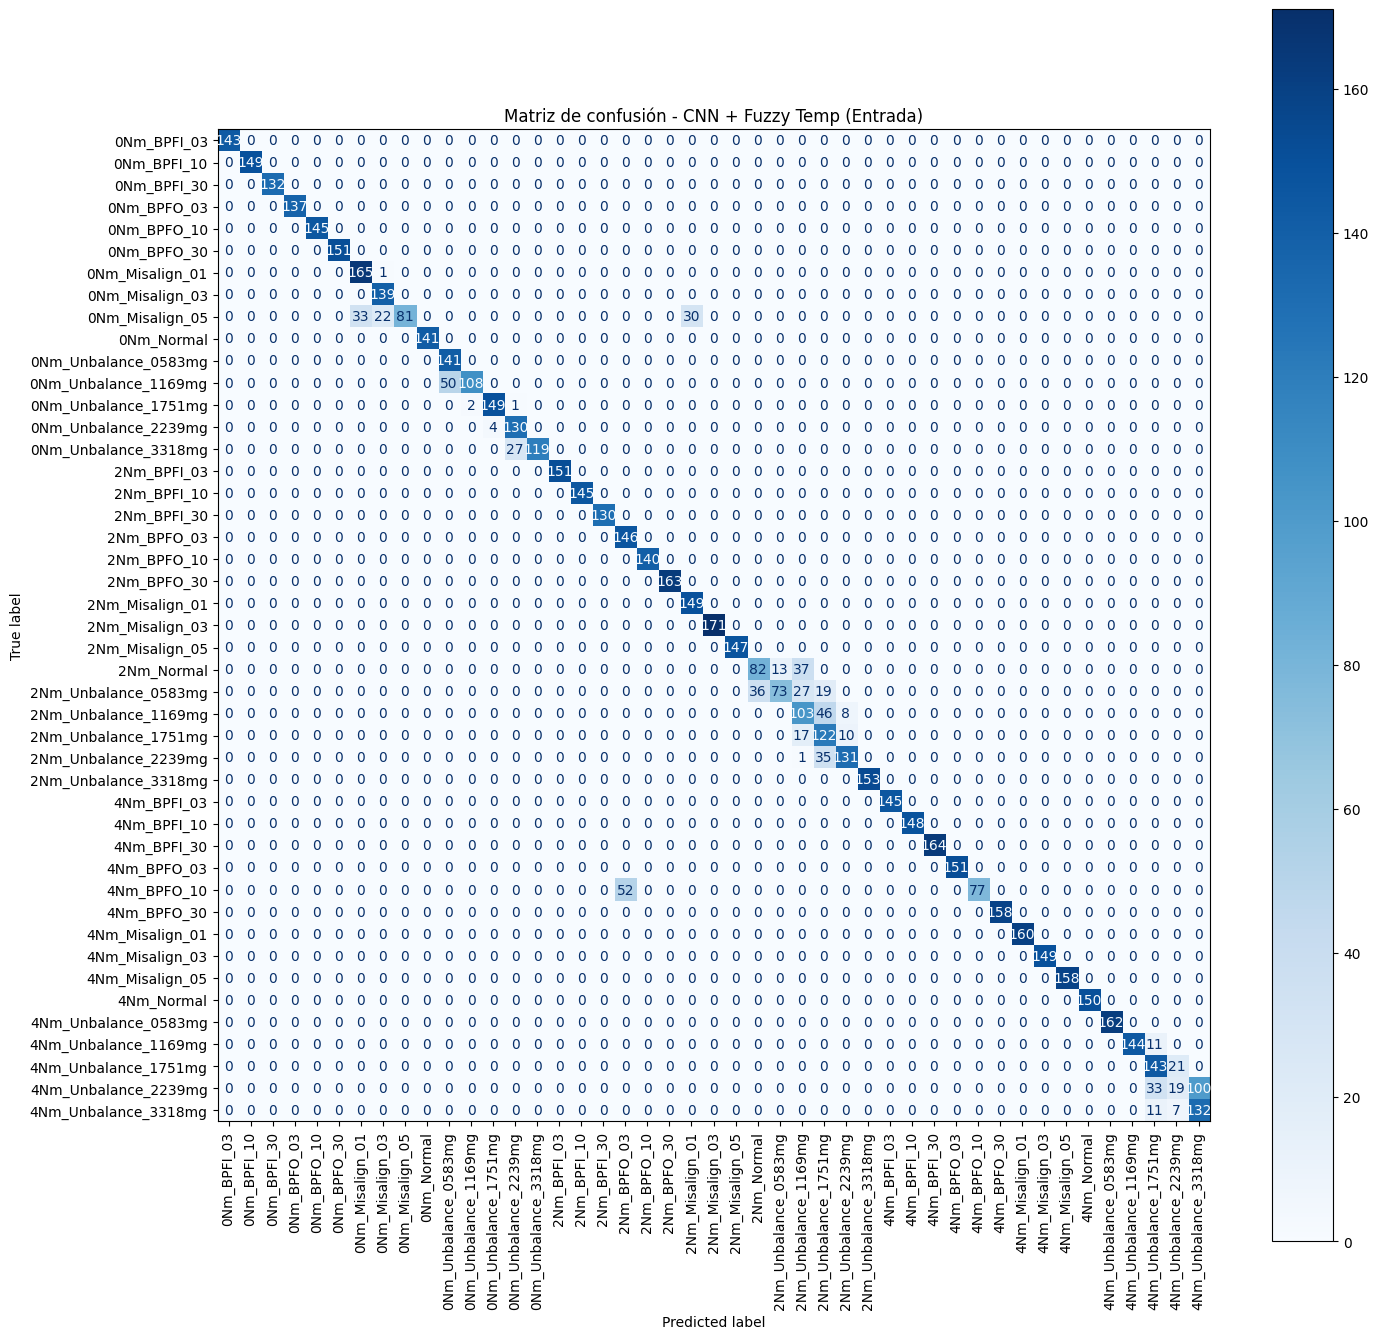

In [ ]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# =====================
# Cargar mejor modelo guardado
# =====================
best_model = CNN_FuzzyTempInput(num_classes).to(device)
best_model.load_state_dict(torch.load("best_model_fuzzy_temp_input.pth", map_location=device))
best_model.eval()

all_labels, all_preds = [], []

# =====================
# Validación
# =====================
with torch.no_grad():
    for x_base, x_temp, y_batch in val_loader:
        x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)

        outputs = best_model(x_base, x_temp)
        preds = outputs.argmax(dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# =====================
# Cohen's Kappa (global)
# =====================
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa (global): {kappa:.4f}")

# =====================
# Matriz de confusión
# =====================
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(16, 16))
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)
plt.title("Matriz de confusión - CNN + Fuzzy Temp (Entrada)")
plt.show()
